In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import joblib

In [ ]:
# === 1. Load Dataset ===
df = pd.read_csv(r"D:\pro1\10th project NASA Hackathon 2025 - Exoplanet Detection\datasets\KOI-data.csv")

In [3]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [4]:
# === 2. Drop Irrelevant Columns ===
drop_cols = [
    'kepid', 'kepoi_name', 'kepler_name', 'koi_tce_delivname',
    'koi_pdisposition', 'koi_vet_date', 'koi_vet_stat',
    'koi_vet_url'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

In [5]:
df.head()

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,1.000,0,0,0,0,9.488036,2.775000e-05,-2.780000e-05,170.538750,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,0.969,0,0,0,0,54.418383,2.479000e-04,-2.480000e-04,162.513840,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.490000e-05,175.850252,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,1.000,0,0,0,0,2.525592,3.761000e-06,-3.760000e-06,171.595550,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [6]:
# === 3. Encode Labels ===
label_col = 'koi_disposition'
le = LabelEncoder()
df[label_col] = le.fit_transform(df[label_col])  # e.g., FALSE POSITIVE=0, CANDIDATE=1, CONFIRMED=2

In [7]:
# === 4. Select Features ===
# Include numeric columns + FP flags
feature_cols = [
    'koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 
    'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    'koi_kepmag'
]

X = df[feature_cols]
y = df[label_col]

In [8]:
# === 5. Feature Engineering ===
X['log_prad'] = np.log1p(X['koi_prad'])
X['log_depth'] = np.log1p(X['koi_depth'])
X['duration_period_ratio'] = X['koi_duration'] / X['koi_period']
X['prad_srad_ratio'] = X['koi_prad'] / X['koi_srad']


C:\Users\asus\AppData\Local\Temp\ipykernel_41296\2534383766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_prad'] = np.log1p(X['koi_prad'])
C:\Users\asus\AppData\Local\Temp\ipykernel_41296\2534383766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_depth'] = np.log1p(X['koi_depth'])
C:\Users\asus\AppData\Local\Temp\ipykernel_41296\2534383766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [9]:
df.head()

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1.000,0,0,0,0,9.488036,2.775000e-05,-2.780000e-05,170.538750,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,0.969,0,0,0,0,54.418383,2.479000e-04,-2.480000e-04,162.513840,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0.000,0,0,0,0,19.899140,1.494000e-05,-1.490000e-05,175.850252,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,2,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1.000,0,0,0,0,2.525592,3.761000e-06,-3.760000e-06,171.595550,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [10]:
# === 6. Handle Missing Values ===
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [11]:
# === 7. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# === 8. Train LightGBM Model with Class Weight ===
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    learning_rate=0.03,
    n_estimators=1000,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',  # handle class imbalance
    random_state=42
)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3834
[LightGBM] [Info] Number of data points in the train set: 7651, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,1000
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [13]:
# === 9. Evaluate Model ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("\nROC-AUC (macro):", roc_auc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.81      0.85      0.83       396
     CONFIRMED       0.90      0.87      0.89       549
FALSE POSITIVE       0.99      0.99      0.99       968

      accuracy                           0.93      1913
     macro avg       0.90      0.90      0.90      1913
  weighted avg       0.93      0.93      0.93      1913


ROC-AUC (macro): 0.98062472839477

Confusion Matrix:
[[336  54   6]
 [ 67 480   2]
 [ 13   0 955]]


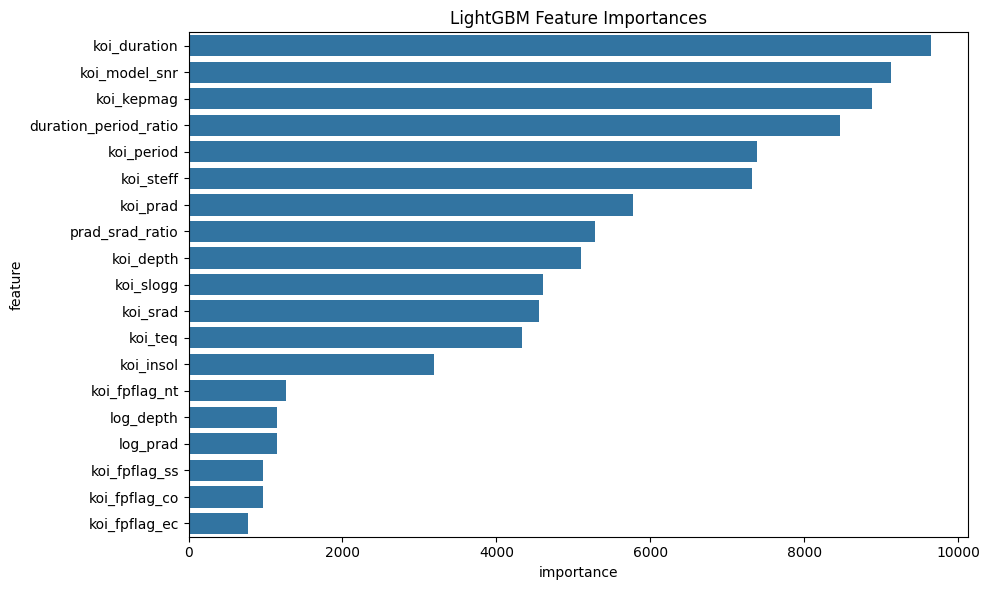

In [15]:
# === 10. Feature Importance ===
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()

In [16]:
# === 11. Save Model ===
joblib.dump((model, le, X.columns.tolist()), "koi_lightgbm.pkl")
print("\n✅ Improved KOI model saved as 'koi_lightgbm_improved.pkl'")


✅ Improved KOI model saved as 'koi_lightgbm_improved.pkl'
